# Submitted By: Mrinal Bhan 
# DSAI 211020428
 

1. Download/search the Stock market dataset from
https://www.kaggle.com/datasets/rohanrao/nifty50-stock-market-data. You have
given the flexibility to use any other stock dataset if found suitable.
2. Apply any two Preprocessing technique to the above datasets.
3. Apply the GRU architecture to the above dataset.
4. Demonstrate the results with various learning rates.
5. Demonstrate the results with various Activation functions.
6. Demonstrate the results with all possible evaluation criteria.
7. Demonstrate the learning results in all possible visualizing ways.
8. Predict the stock market value based on your implemented model.

In [1]:
import itertools
import pandas as pd
import numpy as np
import os
import random 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, RNN, Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_squared_error as mse

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

2023-11-09 21:56:15.271323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 21:56:16.035729: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# general settings
class CFG:
    data_folder = 'archive'
    img_dim1 = 20
    img_dim2 = 10
    nepochs = 6
    seed = 42
    EPOCH = 300
    bsize = 16
    BATCH_SIZE = 1024

    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   


def seed_everything(seed: int = 42) -> None:
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(CFG.seed)

### Load Dataset

<Axes: >

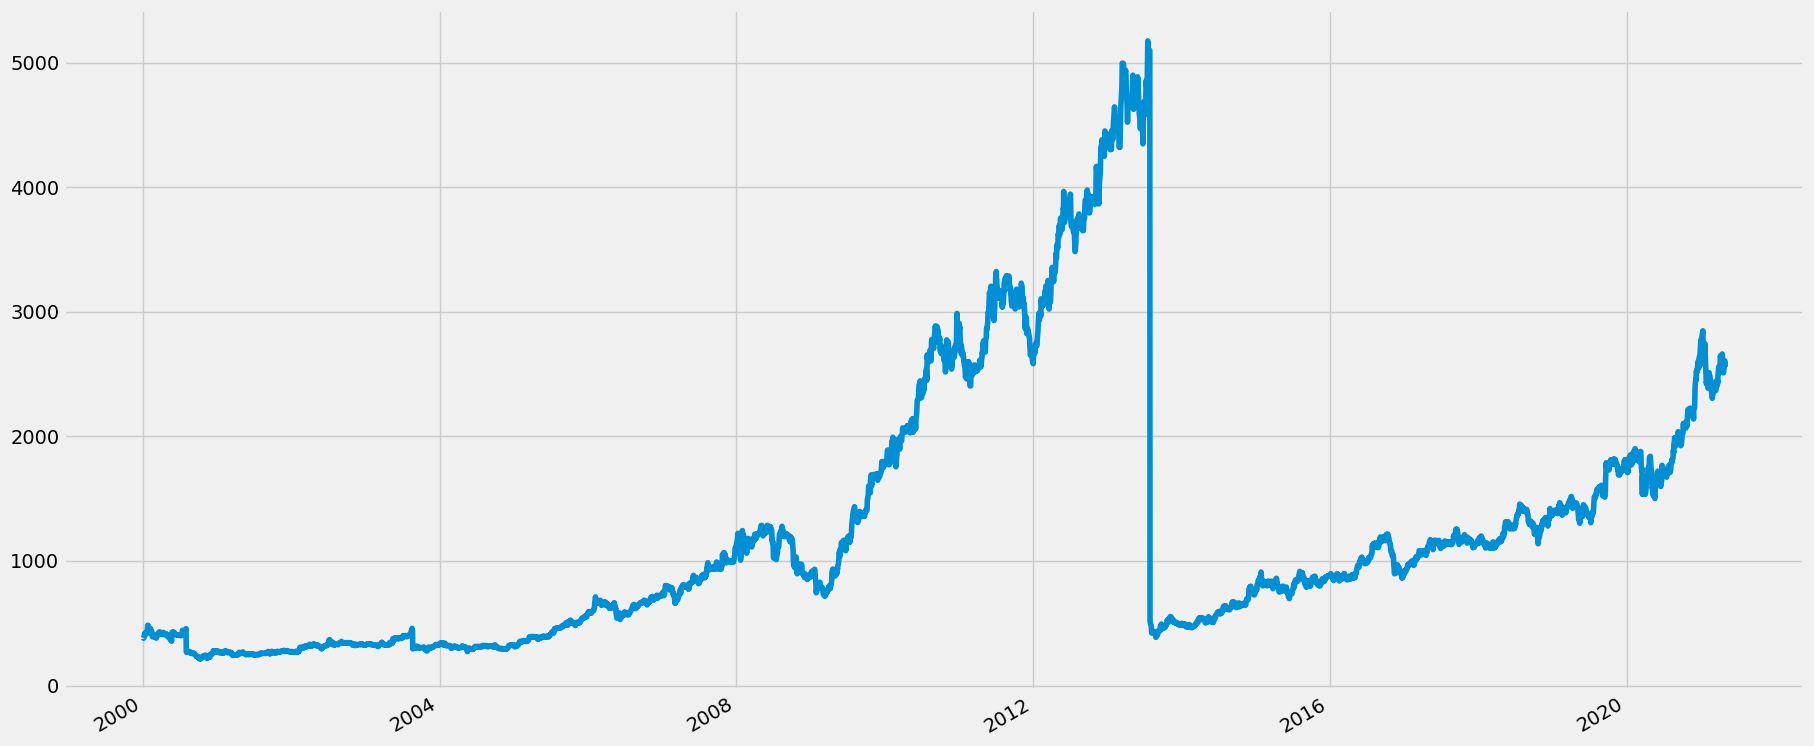

In [3]:
# load the dataset
stock_name = 'CoalIndia'
df = pd.read_csv('archive/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",  inplace=True)
df.VWAP.plot(xlabel = '')

### Preprocessing Data

In [4]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [5]:
def create_dataset(dataset, look_back, look_ahead):
    xdat, ydat = [], []
    for i in range(len(df) - look_back -look_ahead):
        xdat.append(df[i:i+ look_back ,0])
        ydat.append(df[i+ look_back : i + look_back + look_ahead,0])
    xdat, ydat = np.array(xdat), np.array(ydat).reshape(-1,look_ahead)
    return xdat, ydat

In [6]:
# use 50 historical observations, predict 1 step ahead
look_back = 50
look_ahead = 1

xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)

# We only want to forecast a single value for each series => target is a column
print(xdat.shape, ydat.shape)

(5255, 50) (5255, 1)


In [7]:
def prepare_split(xdat, ydat, cutoff = 5000, timesteps = 50):
    xtrain, xvalid = xdat[:cutoff,:], xdat[cutoff:,]
    ytrain, yvalid = ydat[:cutoff,:], ydat[cutoff:,]

    # reshape into [batch size, time steps, dimensionality]
    xtrain = xtrain.reshape(-1, timesteps, 1)
    xvalid = xvalid.reshape(-1, timesteps, 1)

    return xtrain, ytrain, xvalid, yvalid 

In [8]:
xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps = look_back)

print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)

(5000, 50, 1) (255, 50, 1) (5000, 1) (255, 1)


### GRU

In [9]:
def create_model(activation, learning_rate):    
    
    model=Sequential()
    model.add(GRU(10,input_shape= [None,1], return_sequences = True, activation=activation))
    model.add(GRU(10,input_shape= [None,1]))
    model.add(Dense(look_ahead))
    
    model.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=learning_rate))
    return model

In [10]:
look_back = 50
look_ahead = 10

xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps= look_back)

### Taking Different Learning Rates and Activation Functions

In [11]:
model1 = create_model('linear', 0.01)
model2 = create_model('relu', 0.001)
model3 = create_model('tanh', 0.0001)
model4 = create_model('sigmoid', 0.1)

2023-11-09 21:56:17.918746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-09 21:56:18.054600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-09 21:56:18.054735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-09 21:56:18.059973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-09 21:56:18.060061: I tensorflow/compile

In [12]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

In [13]:
model1.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop], verbose=0)

2023-11-09 21:56:33.215208: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-09 21:56:33.645435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-09 21:56:33.938139: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd09f8ad410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-09 21:56:33.938196: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2023-11-09 21:56:33.945261: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-09 21:56:34.196326: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

Restoring model weights from the end of the best epoch: 1.
Epoch 6: early stopping


In [14]:
model2.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop], verbose=0)

Restoring model weights from the end of the best epoch: 1.
Epoch 6: early stopping


In [15]:
model3.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop], verbose=0)

In [16]:
model4.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop], verbose=0)

Restoring model weights from the end of the best epoch: 1.
Epoch 6: early stopping


### Predictions, Resuls, Plots

In [17]:
y_pred1 = model1.predict(xvalid)
y_pred1 = scaler.inverse_transform(y_pred1)
yvalid1 =  scaler.inverse_transform(yvalid)

8/8 [==============================] - 1s 20ms/step


In [18]:
y_pred2 = model2.predict(xvalid)
y_pred2 = scaler.inverse_transform(y_pred2)

8/8 [==============================] - 0s 22ms/step


In [19]:
y_pred3 = model3.predict(xvalid)
y_pred3 = scaler.inverse_transform(y_pred3)

8/8 [==============================] - 1s 5ms/step


In [20]:
y_pred4 = model4.predict(xvalid)
y_pred4 = scaler.inverse_transform(y_pred4)

8/8 [==============================] - 0s 18ms/step


In [21]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

In [22]:
print('LR = 0.0001 -> ', 'RMSE: ' + str(my_rmse(y_pred1, yvalid1)))
print('LR = 0.001 -> ', 'RMSE: ' + str(my_rmse(y_pred2, yvalid1)))
print('LR = 0.01 -> ', 'RMSE: ' + str(my_rmse(y_pred3, yvalid1)))
print('LR = 0.1 -> ', 'RMSE: ' + str(my_rmse(y_pred4, yvalid1)))

LR = 0.0001 ->  RMSE: 114.9648
LR = 0.001 ->  RMSE: 124.0381
LR = 0.01 ->  RMSE: 160.4362
LR = 0.1 ->  RMSE: 106.3669


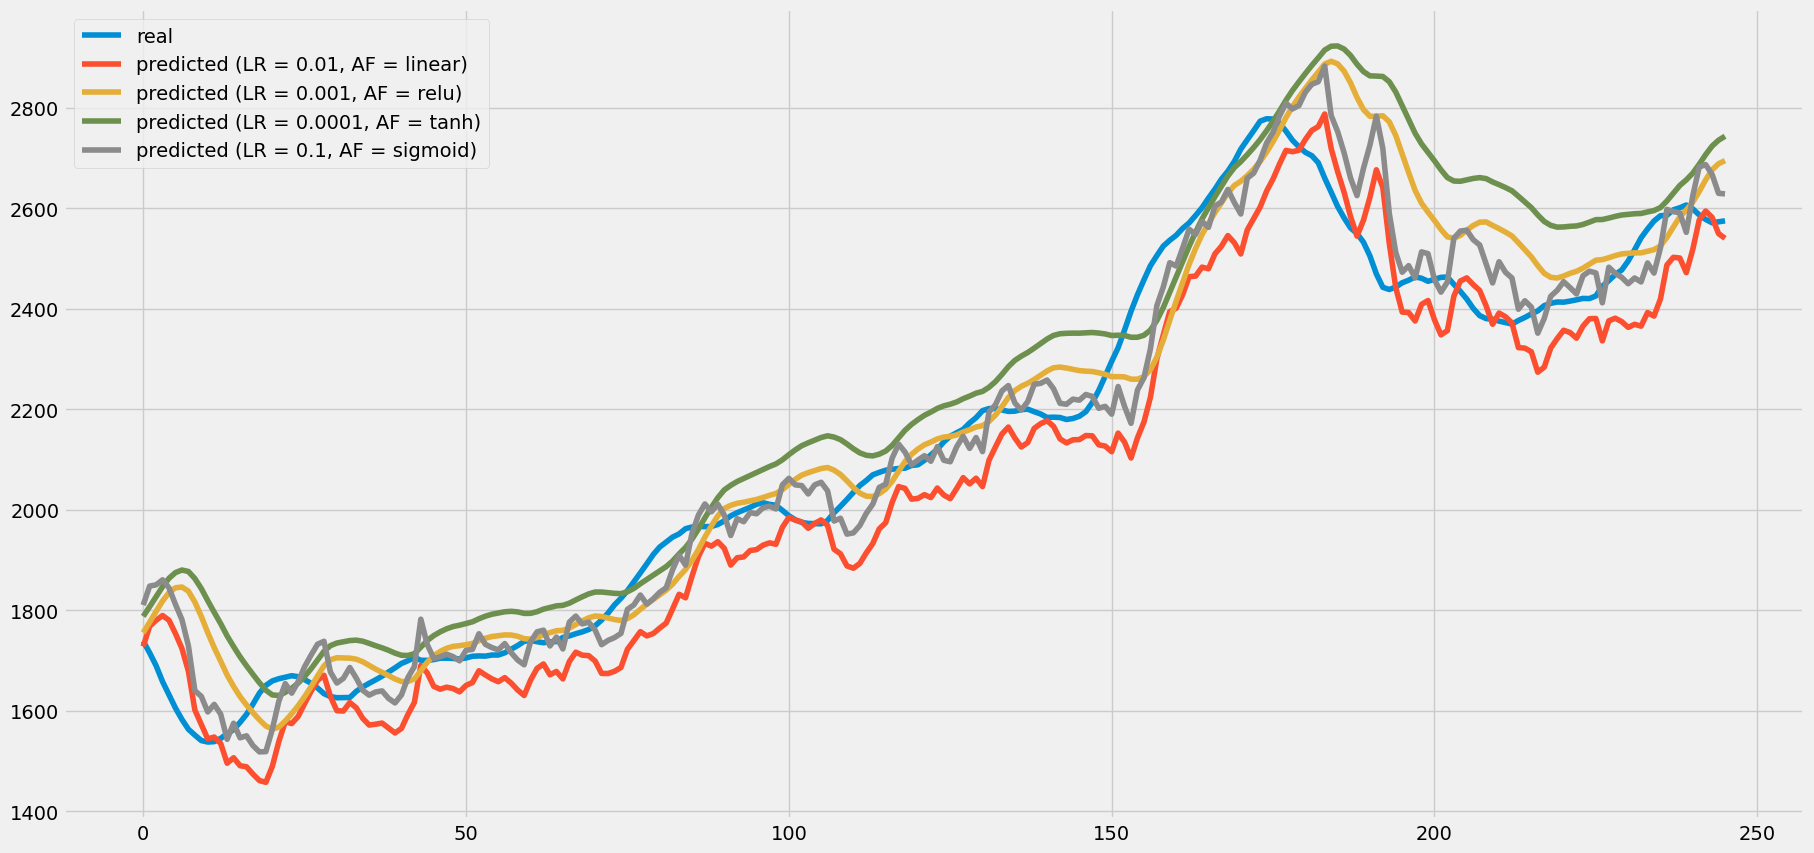

In [23]:
plt.plot(np.mean(yvalid1, axis=1), label = 'real')
plt.plot(np.mean(y_pred1, axis=1), label = 'predicted (LR = 0.01, AF = linear)')
plt.plot(np.mean(y_pred2, axis=1), label = 'predicted (LR = 0.001, AF = relu)')
plt.plot(np.mean(y_pred3, axis=1), label = 'predicted (LR = 0.0001, AF = tanh)')
plt.plot(np.mean(y_pred4, axis=1), label = 'predicted (LR = 0.1, AF = sigmoid)')
plt.ylabel('')
plt.legend()
plt.show()